# Capstone Project HACKTIV8 - Data Classification and Summarization Using IBM Granite (via Replicate)



## LANGKAH 1: INSTALASI & IMPORT LIBRARY

In [1]:
!pip install replicate pandas kagglehub tqdm google-colab matplotlib seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.6/48.6 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 49.9 MB/s eta 0:00:00


In [11]:
import os
import pandas as pd
import replicate
import kagglehub
from tqdm import tqdm
import email
import re
import matplotlib.pyplot as plt
import seaborn as sns
# Jika dijalankan di Google Colab, kita pakai google.colab.userdata untuk secret
try:
    from google.colab import userdata
    TOKEN = userdata.get('TOKEN_ENV')
except ImportError:
    TOKEN = os.getenv('TOKEN_ENV')  # fallback ke env var lokal

## LANGKAH 2: KONFIGURASI REPLICATE API

In [12]:
if not TOKEN:
    raise EnvironmentError("Token API Replicate tidak ditemukan. Pastikan secret 'TOKEN_ENV' telah disetel di Colab atau environment variable.")
os.environ['REPLICATE_API_TOKEN'] = TOKEN

MODEL_NAME = "ibm-granite/granite-3.3-8b-instruct"

## LANGKAH 3: MUAT & EKSTRAKSI DATA

In [16]:
def load_raw_data(sample_size: int = 1000) -> pd.DataFrame:
    print("🔄 Mengunduh dataset Enron...")
    dataset_dir = kagglehub.dataset_download("wcukierski/enron-email-dataset")
    csv_path = os.path.join(dataset_dir, "emails.csv")
    if not os.path.exists(csv_path):
        raise FileNotFoundError(f"File emails.csv tidak ditemukan: {csv_path}")
    df = pd.read_csv(csv_path).sample(sample_size, random_state=42).reset_index(drop=True)
    print(f"✅ Data mentah dimuat: {len(df)} email")
    return df


def extract_email_details(df: pd.DataFrame) -> pd.DataFrame:
    print("🔍 Mengekstrak header & body...")
    records = []
    for _, row in tqdm(df.iterrows(), total=len(df), desc="Ekstraksi"):
        msg = email.message_from_string(row.get('message',''))
        if msg.is_multipart():
            parts = [p for p in msg.walk()
                     if p.get_content_type()=='text/plain' and p.get_content_disposition()!='attachment']
            body = parts[0].get_payload(decode=True).decode(errors='ignore') if parts else ''
        else:
            body = msg.get_payload(decode=True).decode(errors='ignore')
        records.append({
            'Date': msg.get('Date'),
            'From': msg.get('From'),
            'To': msg.get('To'),
            'Subject': msg.get('Subject'),
            'Body': body.strip()
        })
    extracted = pd.DataFrame(records)
    extracted.to_csv('extracted_emails.csv', index=False)
    print("📂 Berkas 'extracted_emails.csv' disimpan")
    return extracted

## LANGKAH 4: KLASIFIKASI & RINGKASAN VIA IBM GRANITE (SUPERVISED)

In [17]:
def classify_and_summarize(df: pd.DataFrame) -> pd.DataFrame:
    print("🚀 Memulai klasifikasi & ringkasan dengan IBM Granite via Replicate...")
    results = []
    for _, row in tqdm(df.iterrows(), total=len(df), desc='Analisis'):
        prompt = (
            "You are an AI email classifier. Classify the email into exactly one of the following categories with no deviations:\n"
            "- Business Operations & Logistics (e.g., project updates, system issues, logistics coordination)\n"
            "- Internal Company & HR (e.g., staff memos, HR-related matters, meeting scheduling)\n"
            "- Financial & Legal (e.g., budgets, contracts, compliance, regulatory)\n"
            "- External Communications & Public Relations (e.g., client communication, partner outreach, media inquiries)\n"
            "- Personal & Informal (e.g., jokes, greetings, informal chats, non-work-related topics)\n\n"
            "Respond in the following format strictly (do not deviate):\n"
            "Category: <selected category>\n"
            "Summary: <concise summary in no more than 3 sentences covering only the key information>\n\n"
            "Do not include any explanation, justification, or extra notes.\n"
            "Do not make up facts or summarize content not present in the body.\n\n"
            f"Email:\nFrom: {row['From']}\nSubject: {row['Subject']}\nBody: {row['Body']}"
        )
        try:
            output = replicate.run(
                MODEL_NAME,
                input={
                    'prompt': prompt,
                    'max_new_tokens': 1000,
                    'temperature': 0.2,
                    'top_p': 0.9,
                    'top_k': 40,
                    'repetition_penalty': 1.2
                }
            )
            text = ''.join(output) if isinstance(output, (list, tuple)) else str(output)
        except Exception as e:
            text = f"Error: {e}"

        match = re.search(r"Category:\s*(.+)", text)
        category = match.group(1).strip() if match else 'Other'
        summary_match = re.search(r"Summary:\s*(.+)", text, re.DOTALL)
        summary = summary_match.group(1).strip() if summary_match else text.strip()

        results.append({
            'Date': row['Date'],
            'From': row['From'],
            'To': row['To'],
            'Subject': row['Subject'],
            'Category': category,
            'Summary': summary
        })
    df_res = pd.DataFrame(results)
    df_res.to_csv('final_analysis_results.csv', index=False)
    print("📂 Berkas 'final_analysis_results.csv' disimpan dengan kolom Category & Summary")
    return df_res

## LANGKAH 5: EDA

In [18]:
def eda(df: pd.DataFrame):
    print("📊 Melakukan Exploratory Data Analysis...")
    sns.set_style("whitegrid")

    plt.figure(figsize=(10,6))
    ax = sns.countplot(data=df, x='Category', palette='Set2', order=df['Category'].value_counts().index)
    plt.title("Distribusi Kategori Email", fontsize=14)
    plt.xticks(rotation=30)
    plt.xlabel("Kategori")
    plt.ylabel("Jumlah Email")

    total = len(df)
    for p in ax.patches:
        count = p.get_height()
        percentage = 100 * count / total
        ax.annotate(f'{count} ({percentage:.1f}%)', (p.get_x() + p.get_width() / 2., count),
                    ha='center', va='center', fontsize=10, color='black', xytext=(0, 10), textcoords='offset points')

    plt.tight_layout()
    plt.show()

    print("\n🔍 Analytical Result:")
    counts = df['Category'].value_counts()
    percentages = df['Category'].value_counts(normalize=True) * 100
    result_df = pd.DataFrame({'Count': counts, 'Percentage': percentages.round(2)})
    print(result_df)

    print("\n💡 Insight & Findings:")
    most_common = counts.idxmax()
    print(f"- Kategori paling sering muncul: {most_common}.")
    print(f"- Total email dianalisis: {total}.")
    print("- Terdapat kecenderungan komunikasi yang tinggi dalam topik tersebut.")

    print("\n✅ Recommendations:")
    if most_common == 'Internal Company & HR':
        print("- Perkuat sistem manajemen internal dan dokumentasi HR.")
    elif most_common == 'Financial & Legal':
        print("- Lakukan audit internal reguler dan perkuat kepatuhan terhadap hukum.")
    elif most_common == 'Business Operations & Logistics':
        print("- Tingkatkan otomasi dan pelacakan proyek serta logistik harian.")
    elif most_common == 'External Communications & Public Relations':
        print("- Perluas strategi komunikasi eksternal dan hubungan media.")
    elif most_common == 'Personal & Informal':
        print("- Evaluasi etika komunikasi dan produktivitas email internal.")

## LANGKAH 6: FINAL

🔄 Mengunduh dataset Enron...
✅ Data mentah dimuat: 1000 email
🔍 Mengekstrak header & body...


Ekstraksi: 100%|██████████| 1000/1000 [00:00<00:00, 4907.99it/s]


📂 Berkas 'extracted_emails.csv' disimpan
🚀 Memulai klasifikasi & ringkasan dengan IBM Granite via Replicate...


Analisis: 100%|██████████| 1000/1000 [12:08<00:00,  1.37it/s]
/tmp/ipython-input-18-3833453284.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(data=df, x='Category', palette='Set2', order=df['Category'].value_counts().index)


📂 Berkas 'final_analysis_results.csv' disimpan dengan kolom Category & Summary
📊 Melakukan Exploratory Data Analysis...


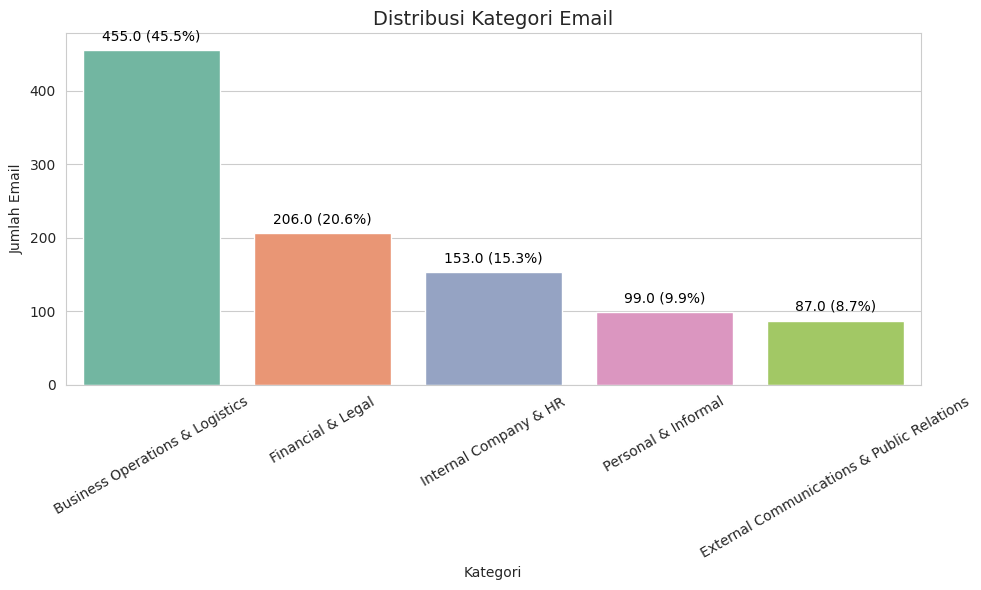


🔍 Analytical Result:
                                            Count  Percentage
Category                                                     
Business Operations & Logistics               455        45.5
Financial & Legal                             206        20.6
Internal Company & HR                         153        15.3
Personal & Informal                            99         9.9
External Communications & Public Relations     87         8.7

💡 Insight & Findings:
- Kategori paling sering muncul: Business Operations & Logistics.
- Total email dianalisis: 1000.
- Terdapat kecenderungan komunikasi yang tinggi dalam topik tersebut.

✅ Recommendations:
- Tingkatkan otomasi dan pelacakan proyek serta logistik harian.
✅ Proses selesai. Berikut 5 baris pertama hasil:
                                 Date                      From                                                                                                                         To                   Subject       

In [19]:
def main():
    raw = load_raw_data(sample_size=1000)
    extracted = extract_email_details(raw)
    final_df = classify_and_summarize(extracted)
    eda(final_df)
    print("✅ Proses selesai. Berikut 5 baris pertama hasil:")
    print(final_df.head().to_string(index=False))

if __name__ == '__main__':
    main()